In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

# Load required packages

In [3]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scvelo as scv
import scanpy as sc
import seaborn as sns
import torch
import gc
import importlib

In [4]:
import scvi
scvi.settings.seed = 0

Global seed set to 0


# Load neural networks classes for noSpliceVelo

In [5]:
# Add path to src
import sys
dir_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(dir_path)

In [6]:
# firt VAE model
import scvi_modified_capture_efficiency_model 

# second VAE model; noSpliceVelo model
import nosplicevelo_model

In [7]:
importlib.reload(scvi_modified_capture_efficiency_model)
importlib.reload(nosplicevelo_model)

<module 'nosplicevelo_model' from '/media/atheistpoet/TarunHDD/maslov_lab/code/noSpliceVelo/src/nosplicevelo_model.py'>

In [8]:
from scvi_modified_capture_efficiency_model import SCVIModified
from nosplicevelo_model import noSpliceVelo

# load pancreas dataset

## get data from scVelo with spliced and unspliced counts

In [9]:
# load data
adata = scv.datasets.pancreas()

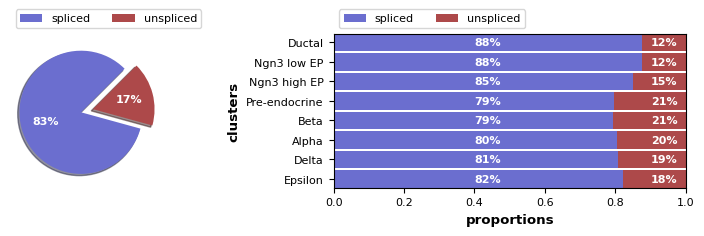

In [10]:
# plot proportion of spliced/unspliced counts
scv.pl.proportions(adata)

In [11]:
# filtering and normalization
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [14]:
# load pancreas data already processed and with velocities
# anndata object available at Mahajan, Tarun (2024). adata_pancrease_nosplicevelo.h5ad. 
# figshare. Dataset. https://doi.org/10.6084/m9.figshare.27021841.v1
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', \
                                        "data",\
                                        "pancreas_endocrinogenesis"))
os.makedirs(dir_path, exist_ok=True)
filname = os.path.join(dir_path, \
                       f'adata_pancrease_nosplicevelo' + \
                       f'.h5ad')
adata_pan = ad.read_h5ad(filname)

# mu and var from the first VAE model
mu_scvi_smooth = adata_pan.layers['mu'].copy()
var_scvi_smooth = adata_pan.layers['std'].copy()**2.0

In [15]:
# match the order of cells in adata and adata_pan
adata_pan = adata_pan[adata.obs_names, :].copy()

In [24]:
adata_pan.shape

(3696, 991)

In [25]:
adata_pan

AnnData object with n_obs × n_vars = 3696 × 991
    obs: 'capture_efficiency', 'cell_id', '_scvi_batch', '_scvi_labels', 'velocity_gene_self_transition', 'velocity_geneCell_self_transition', 'velocity_var_gene_self_transition', 'velocity_var_geneCell_self_transition', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'umap', 'velocity_gene_graph', 'velocity_gene_graph_neg', 'velocity_gene_params', 'velocity_geneCell_graph', 'velocity_geneCell_graph_neg', 'velocity_geneCell_params', 'velocity_var_gene_graph', 'velocity_var_gene_graph_neg', 'velocity_var_gene_params', 'velocity_var_geneCell_graph', 'velocity_var_geneCell_graph_neg', 'velocity_var_geneCell_params', 'clusters_colors'
    obsm: 'X_latent', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'velocity_geneCell_umap'
    layers: 'counts', 'log_counts', 'mu', 'mu_gene', 'mu_geneCell', 'mu_unsmooth', 'p

# Figures for noSpliceVelo

## Figures 3a and 3b

In [18]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_pan, xkey="mu_gene", vkey="velocity_gene")

computing velocity graph (using 1/16 cores)
    finished (0:00:05) --> added 
    'velocity_gene_graph', sparse matrix with cosine correlations (adata.uns)


In [19]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_pan, xkey="mu_geneCell", vkey="velocity_geneCell")

computing velocity graph (using 1/16 cores)
    finished (0:00:05) --> added 
    'velocity_geneCell_graph', sparse matrix with cosine correlations (adata.uns)


In [20]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_pan, xkey="var_gene", vkey="velocity_var_gene")

computing velocity graph (using 1/16 cores)
    finished (0:00:04) --> added 
    'velocity_var_gene_graph', sparse matrix with cosine correlations (adata.uns)


In [21]:
import new_velocity_graph
# new_velocity_graph.velocity_graph(adata_pan_genes, xkey="Ms", vkey="velocity")
new_velocity_graph.velocity_graph(adata_pan, xkey="var_geneCell", vkey="velocity_var_geneCell")

computing velocity graph (using 1/16 cores)
    finished (0:00:04) --> added 
    'velocity_var_geneCell_graph', sparse matrix with cosine correlations (adata.uns)


### Figure 3a. velocity stream for variance of expression

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_var_geneCell_umap_orig', embedded velocity vectors (adata.obsm)


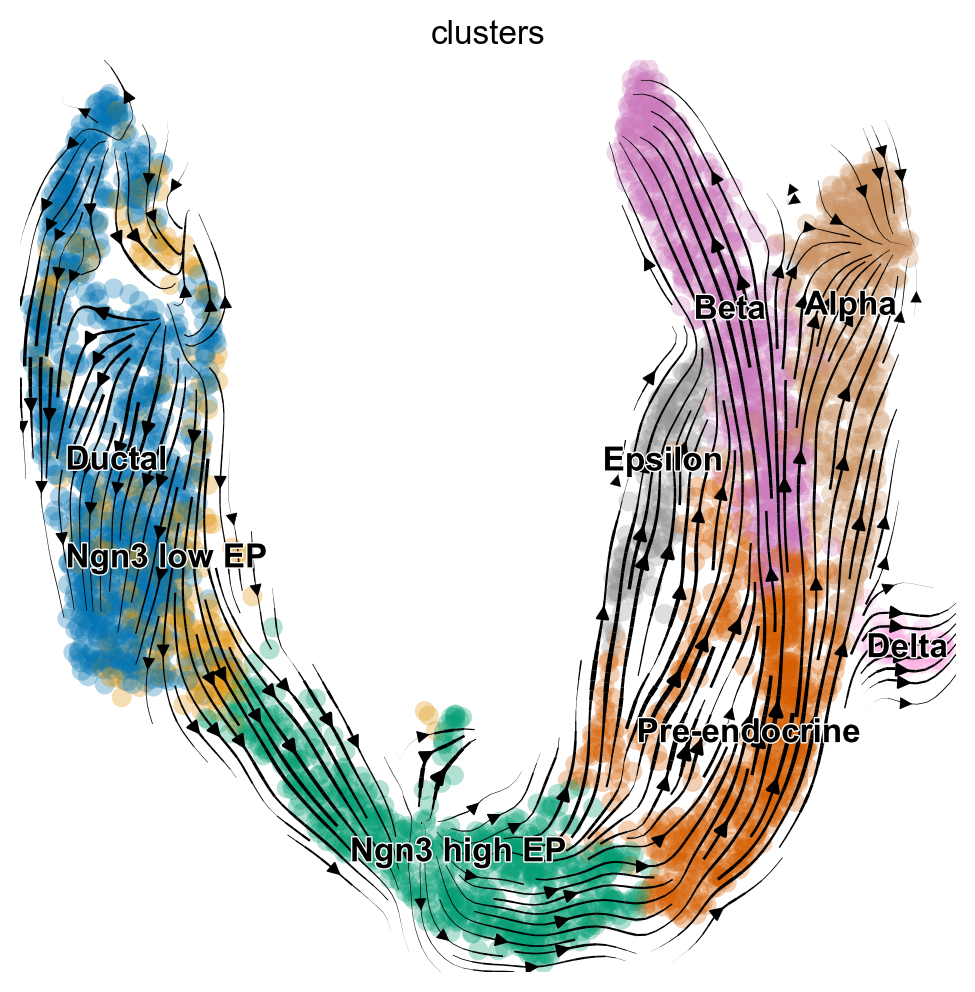

In [28]:
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

# 20240519 Cluster genes into branches
# not filtering genes by cyclical pattern, initial timing by KRT19, sampled only 500 cells
scv.set_figure_params('scvelo')
import new_velocity_embedding_stream
adata_tmp2 = adata[adata_pan.obs_names, :].copy()
adata_pan.obsm['X_umap_orig'] = adata_tmp2.obsm['X_umap'].copy()
adata_pan.uns['clusters_colors'] = col_palette.copy()
adata_pan.obs['clusters'] = adata_tmp2.obs['clusters'].values.copy()
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_pan, \
                                                        basis='umap_orig', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity_var_geneCell', density=3)

### Figure 3b. Velocity stream for mean of gene expression

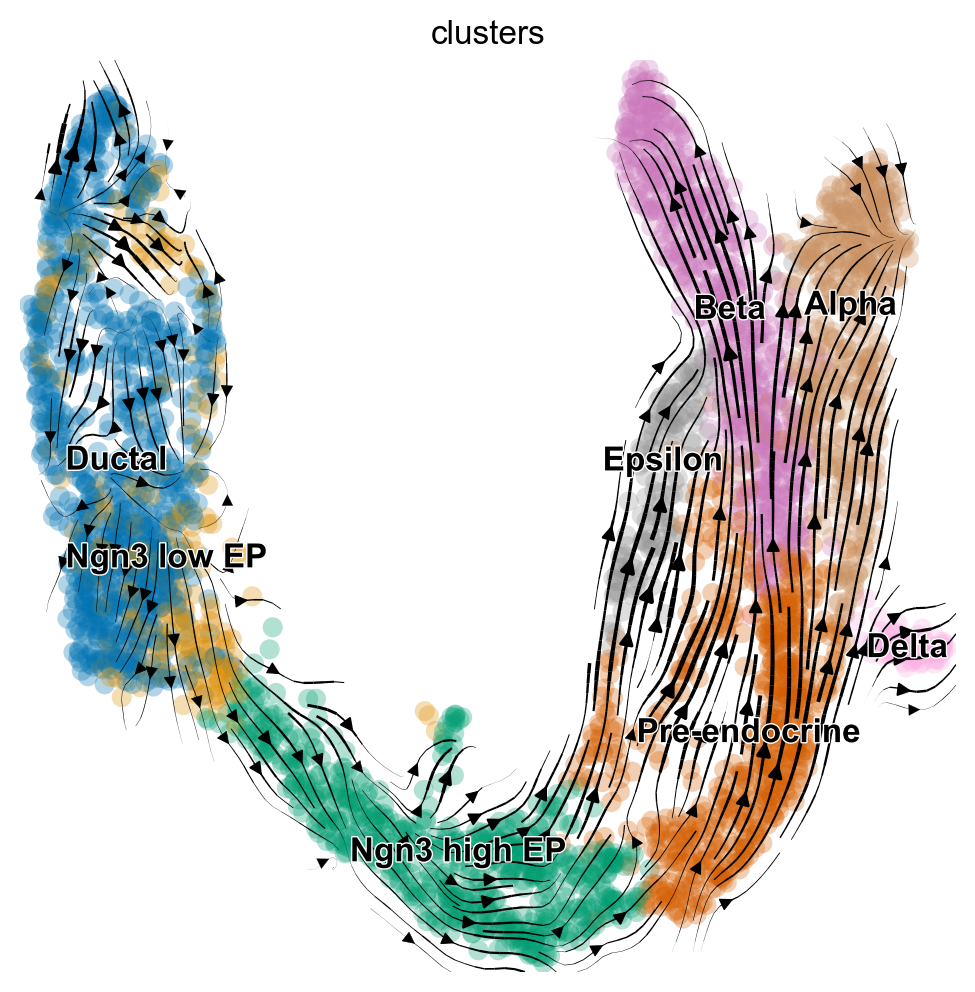

In [30]:
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

# 20240519 Cluster genes into branches
# not filtering genes by cyclical pattern, initial timing by KRT19, sampled only 500 cells
scv.set_figure_params('scvelo')
import new_velocity_embedding_stream
adata_tmp2 = adata[adata_pan.obs_names, :].copy()
adata_pan.obsm['X_umap_orig'] = adata_tmp2.obsm['X_umap'].copy()
adata_pan.uns['clusters_colors'] = col_palette.copy()
adata_pan.obs['clusters'] = adata_tmp2.obs['clusters'].values.copy()
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_pan, \
                                                        basis='umap_orig', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity_geneCell', density=3)

## Figures 3e and 3i

### Figure 3e: variance vs mean for Ppp3ca

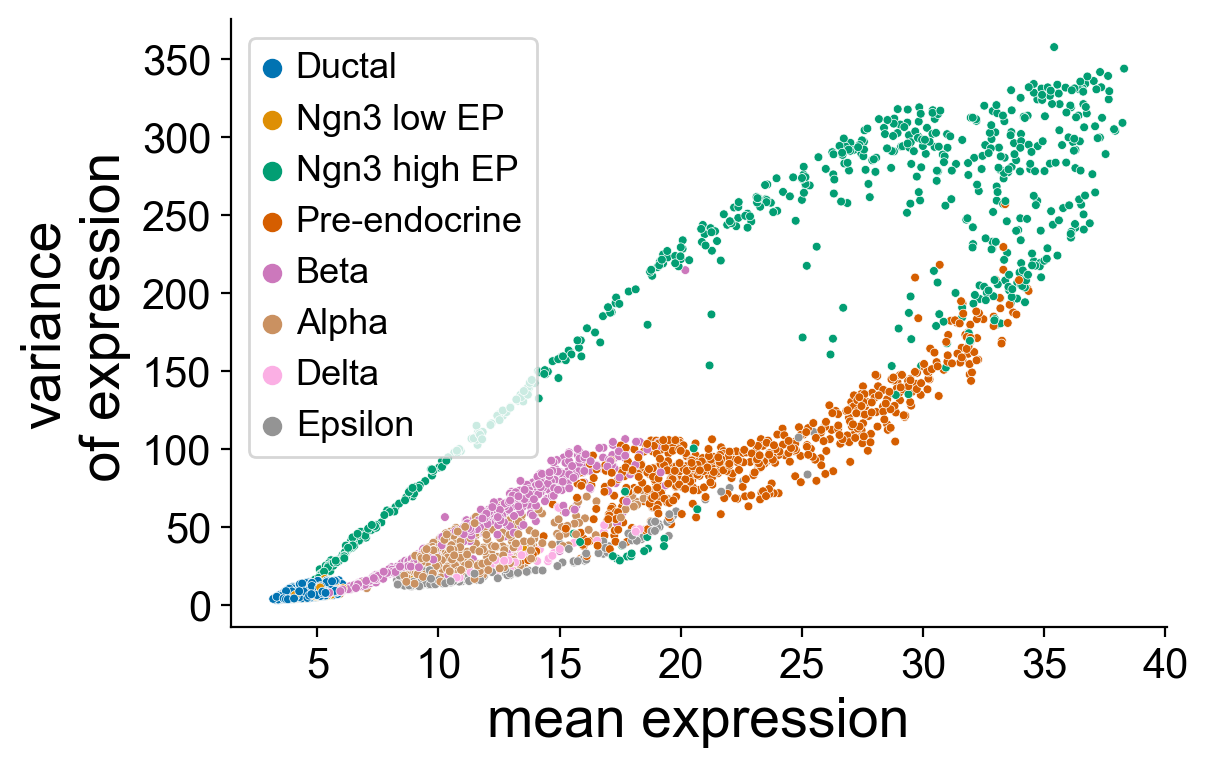

In [33]:
gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_ = np.where(adata_pan.var_names == gene_ensb)[0][0]
x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
plt_ = sns.scatterplot(x=x, y=(y), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)

plt_.set_xlabel("mean expression", fontsize=20)
plt_.set_ylabel("variance\n of expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend(fontsize=13)
sns.despine()

### Figure 3i: variance vs mean for Map1b

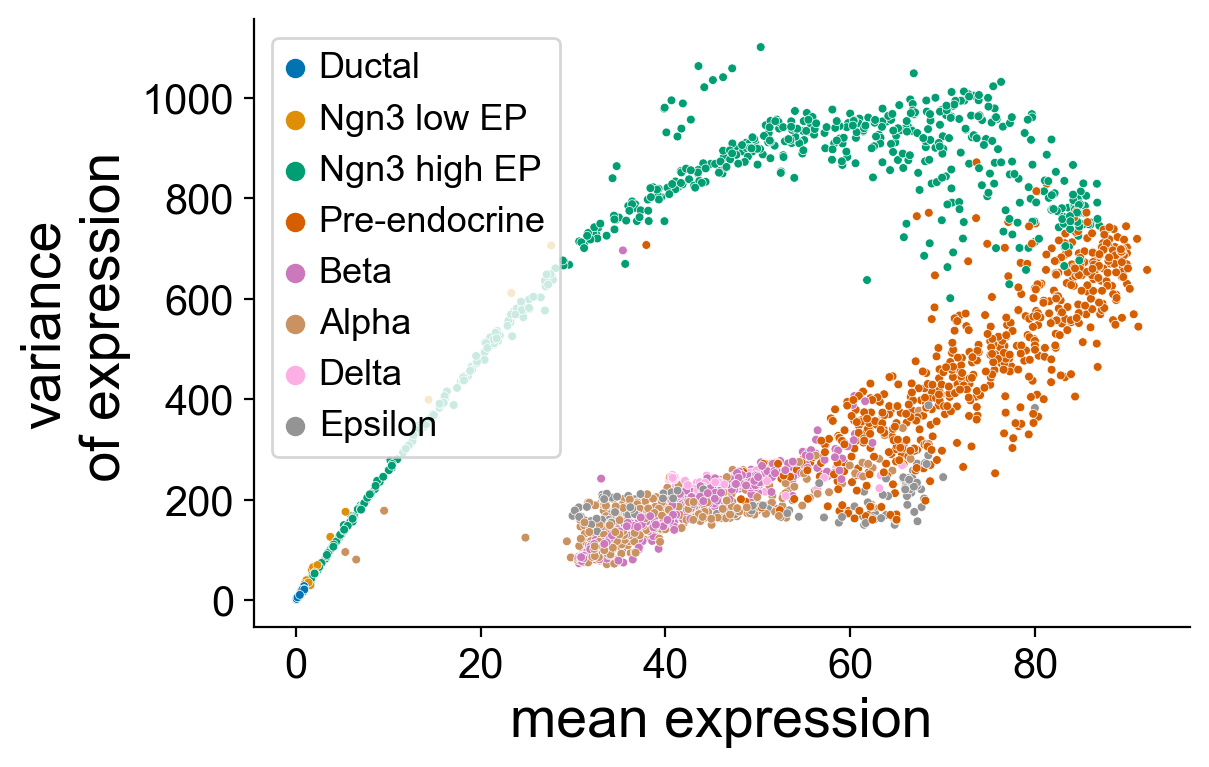

In [34]:
gene_ensb = "ENSMUSG00000052727" # Ppp3ca
gene_ = np.where(adata_pan.var_names == gene_ensb)[0][0]
x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
plt_ = sns.scatterplot(x=x, y=(y), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)

plt_.set_xlabel("mean expression", fontsize=20)
plt_.set_ylabel("variance\n of expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend(fontsize=13)
sns.despine()

## Figures 3f, 3j, and 3m: Mean expression vs pseudotime plots, and pseudtotime heatmap

### Figure 3m: pseudotime heatmap

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


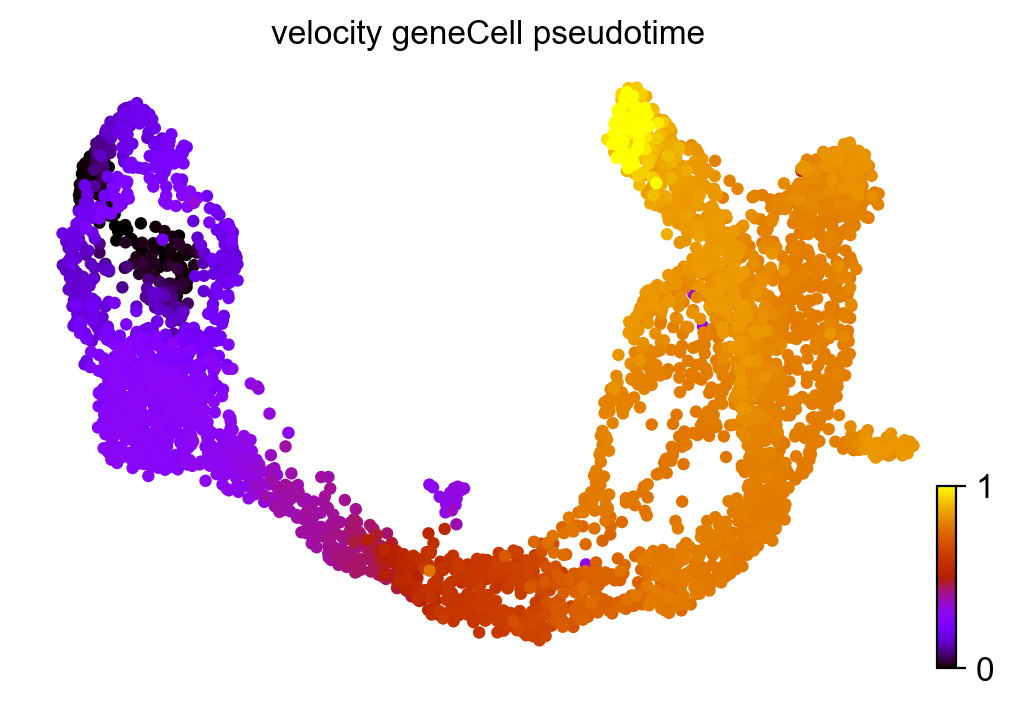

In [36]:
scv.tl.velocity_pseudotime(adata_pan, \
                           vkey="velocity_geneCell")
scv.pl.scatter(adata_pan, color='velocity_geneCell_pseudotime', color_map='gnuplot', size=80, \
               basis="umap_orig")

### Figure 3f: Mean expression vs pseudotime for Ppp3ca

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


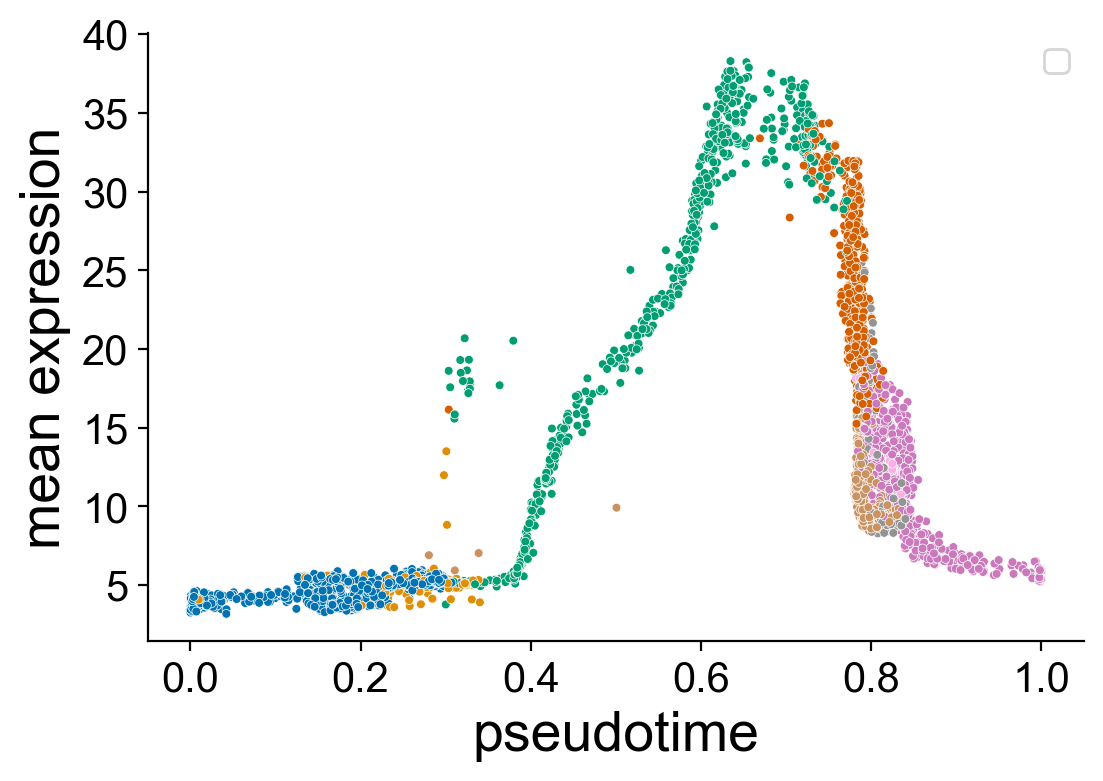

In [38]:

gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_ = np.where(adata_pan.var_names == gene_ensb)[0]
# y = mu_scvi_smooth[:, gene_].copy()
y = adata_pan.layers['mu'][:, gene_].copy()
x = adata_pan.obs['velocity_geneCell_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("mean expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()

### Figure 3j: Mean expression vs pseudotime for Map1b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


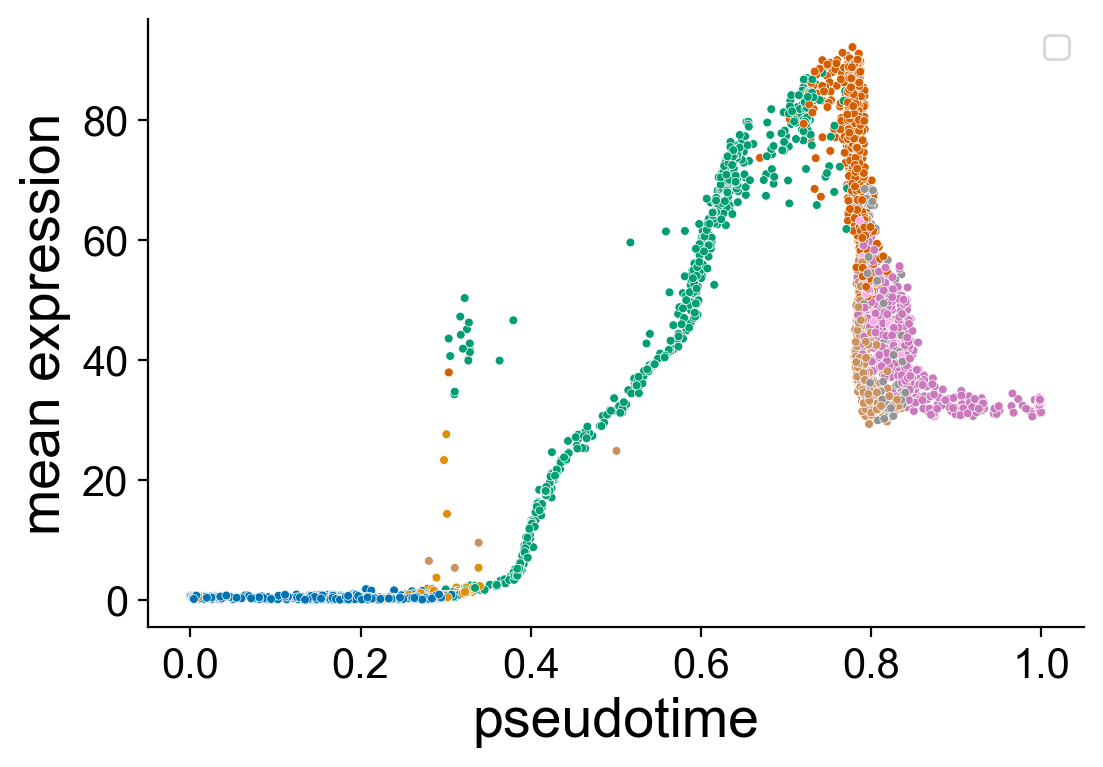

In [39]:

gene_ensb = "ENSMUSG00000052727" # Map1b
gene_ = np.where(adata_pan.var_names == gene_ensb)[0]
# y = mu_scvi_smooth[:, gene_].copy()
y = adata_pan.layers['mu'][:, gene_].copy()
x = adata_pan.obs['velocity_geneCell_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("mean expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()

# Figures for scVelo

In [40]:
# load pancreas data already processed and with velocities for scVelo
# anndata object available at Mahajan, Tarun (2024). adata_pancreas_scvelo.h5ad. 
# figshare. Dataset. https://doi.org/10.6084/m9.figshare.27021838.v1
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', "data", \
                                        "pancreas_endocrinogenesis"))
filname = os.path.join(dir_path, \
                       f'adata_pancreas_scvelo.h5ad')
adata_scvelo = ad.read_h5ad(filname)

In [41]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_scvelo)

computing velocity graph (using 1/16 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [42]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_scvelo, vkey="velocity_u", xkey="Mu")

computing velocity graph (using 1/16 cores)
    finished (0:00:09) --> added 
    'velocity_u_graph', sparse matrix with cosine correlations (adata.uns)


## Figures 3c and 3d

### Figure 3c: velocity stream for unspliced for scVelo

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_u_umap', embedded velocity vectors (adata.obsm)


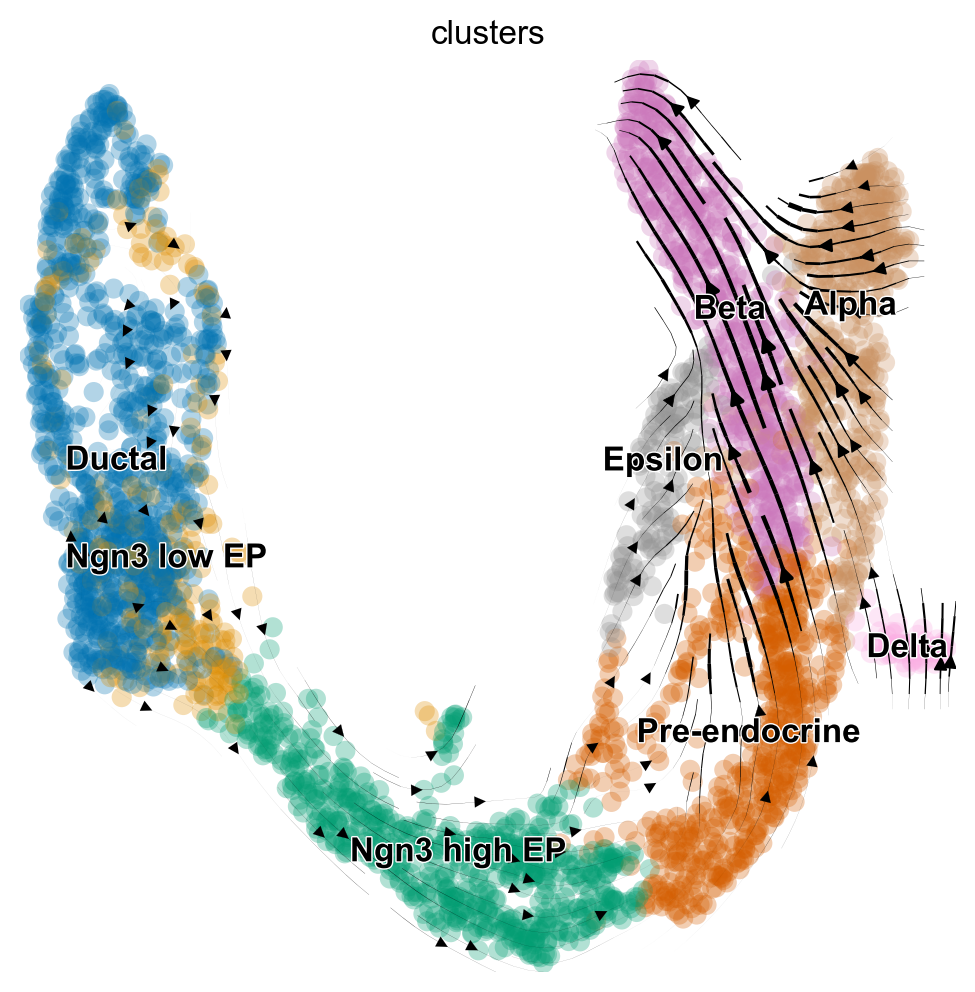

In [45]:
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
adata_tmp1 = adata_scvelo.copy()
adata_tmp1.uns['clusters_colors'] = col_palette.copy()

scv.set_figure_params('scvelo')
import new_velocity_embedding_stream
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_tmp1, \
                                                        basis='umap', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity_u')

### Figure 3c: velocity stream for spliced for scVelo

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


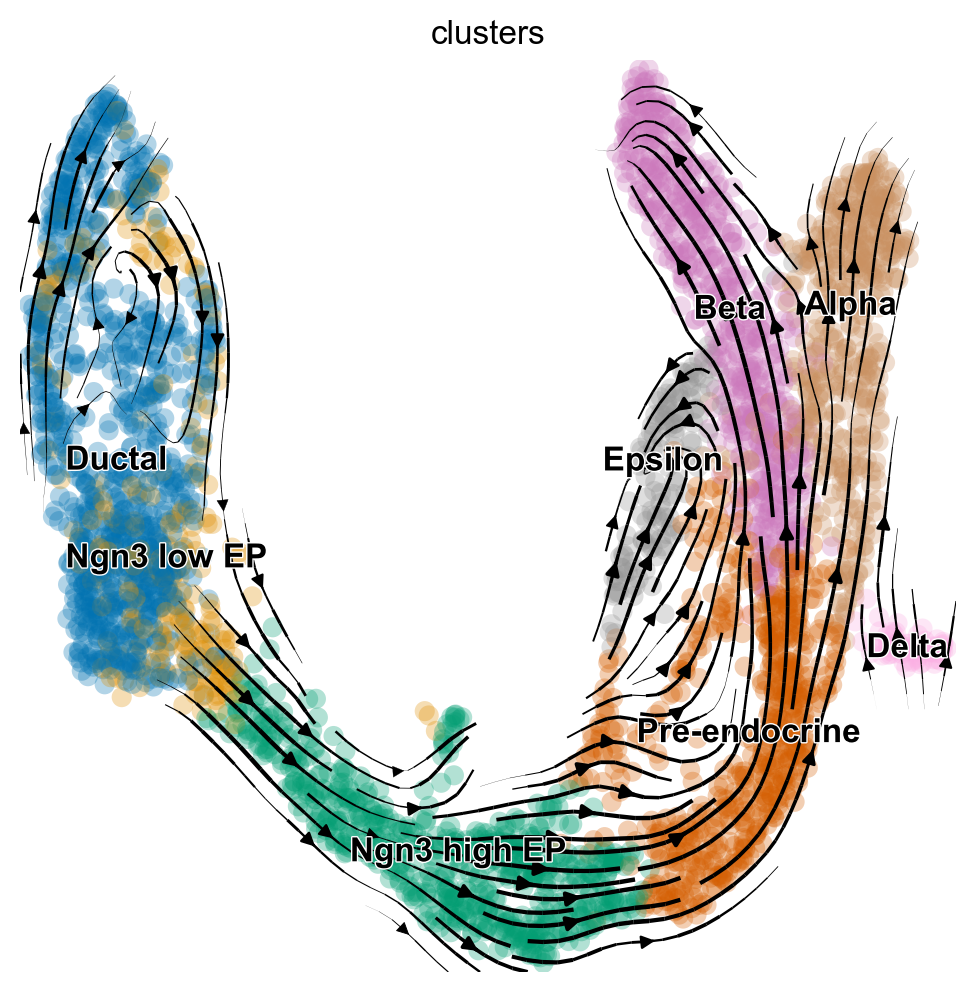

In [47]:
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
adata_tmp1 = adata_scvelo.copy()
adata_tmp1.uns['clusters_colors'] = col_palette.copy()

scv.set_figure_params('scvelo')
import new_velocity_embedding_stream
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_tmp1, \
                                                        basis='umap', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity')

## Figures 3g, 3k, and 3n: Mean expression vs pseudotime plots, and pseudtotime heatmap

### Figure 3n: pseudotime heatmap

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/atheistpoet/anaconda3/envs/scvi_cell_cycle_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


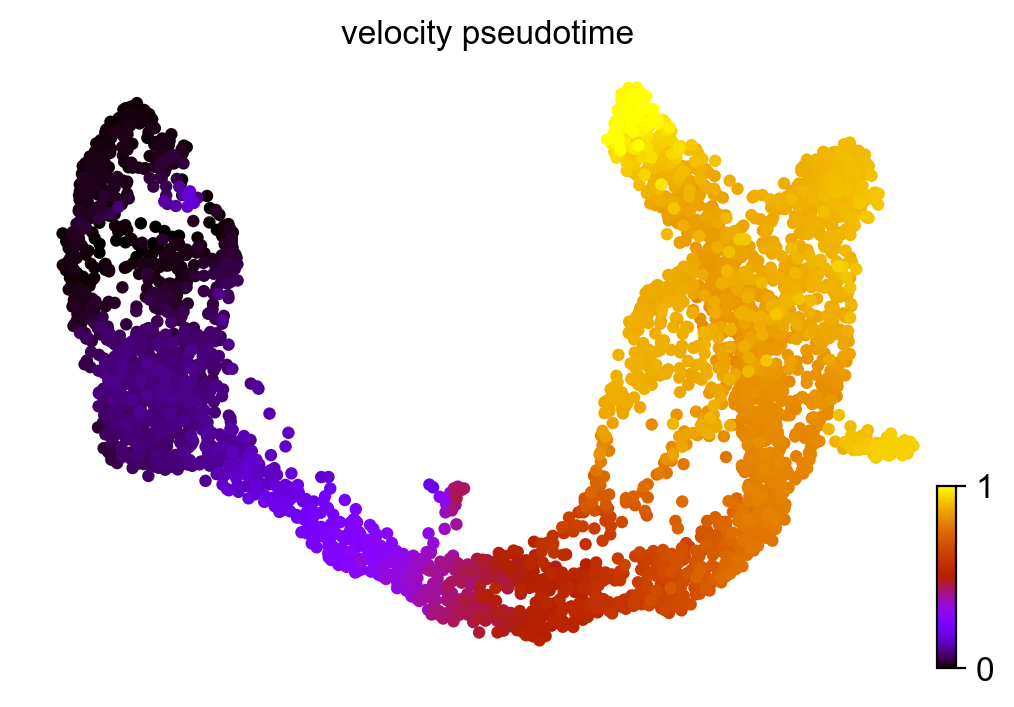

In [49]:
scv.tl.velocity_pseudotime(adata_scvelo)
scv.pl.scatter(adata_scvelo, color='velocity_pseudotime', color_map='gnuplot', size=80)

### Figure 3h: spliced expression vs pseudotime for Ppp3ca

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


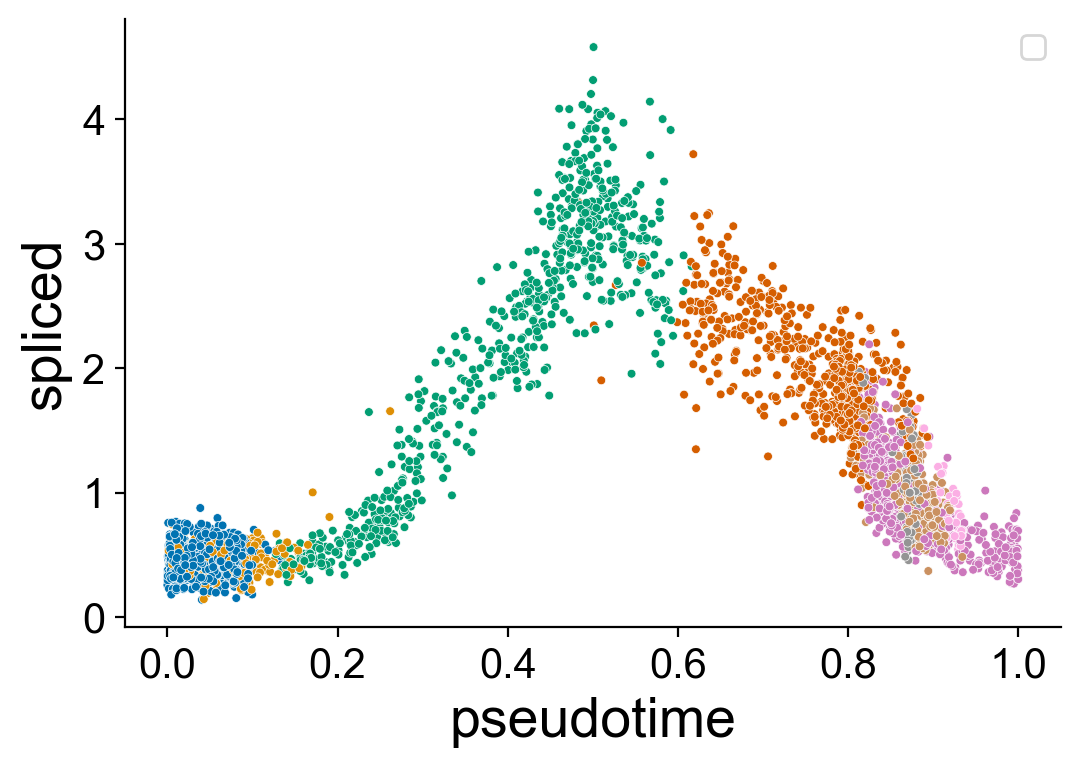

In [52]:
gene_name = "Ppp3ca"
gene_ = np.where(adata_scvelo.var_names == gene_name)[0]
y = adata_scvelo.layers['Ms'][:, gene_].copy()
x = adata_scvelo.obs['velocity_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
# plt_.set_xlabel("velocity pseudotime", fontsize=20)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("spliced", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()

### Figure 3l: spliced expression vs pseudotime for Map1b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


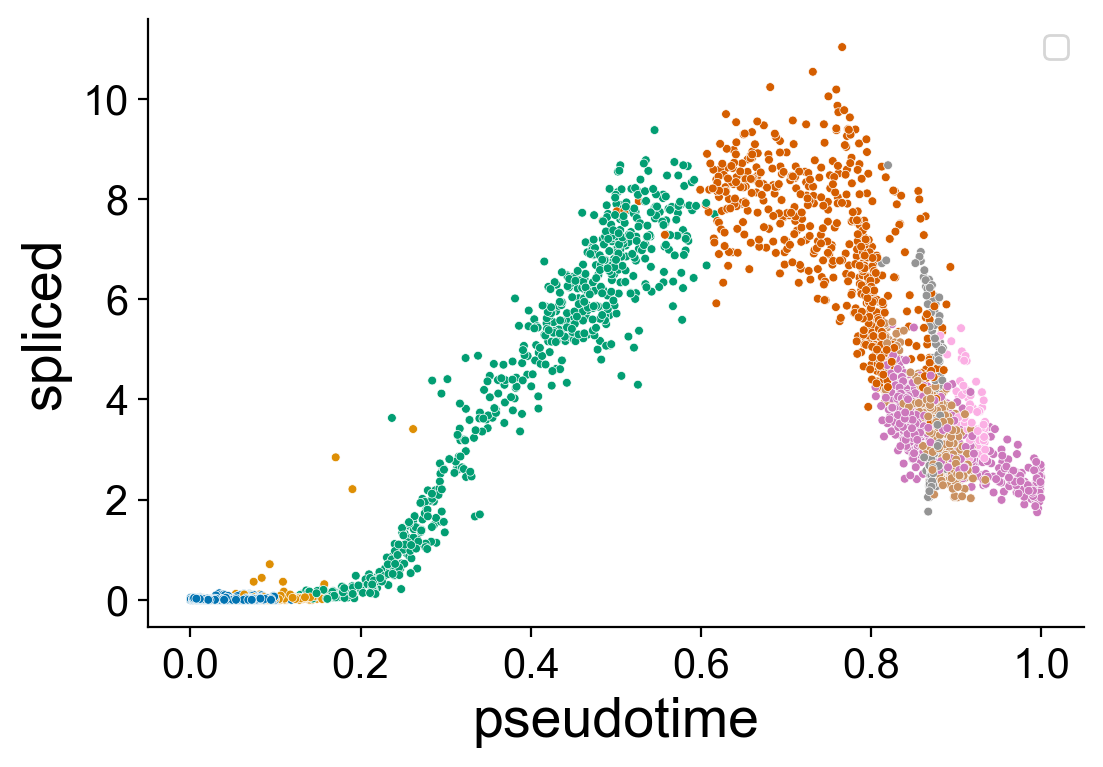

In [55]:
gene_name = "Map1b"
gene_ = np.where(adata_scvelo.var_names == gene_name)[0]
y = adata_scvelo.layers['Ms'][:, gene_].copy()
x = adata_scvelo.obs['velocity_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
# plt_.set_xlabel("velocity pseudotime", fontsize=20)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("spliced", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()

## Figures 3g, and 3k: Unspliced vs spliced expression of Ppp3ca and Map1b

In [57]:
import scvelo as scv
from scvelo.pl.simulation import compute_dynamics
ut = np.zeros(adata_scvelo.shape)
st = np.zeros(adata_scvelo.shape)
for gene_ in np.arange(adata_scvelo.shape[1]):
    gene_name = adata_scvelo.var_names[gene_]
    _, ut[:, gene_], st[:, gene_] = compute_dynamics(adata_scvelo, basis=gene_name, key="fit")

### Figure 3g: unspliced vs spliced for Ppp3ca

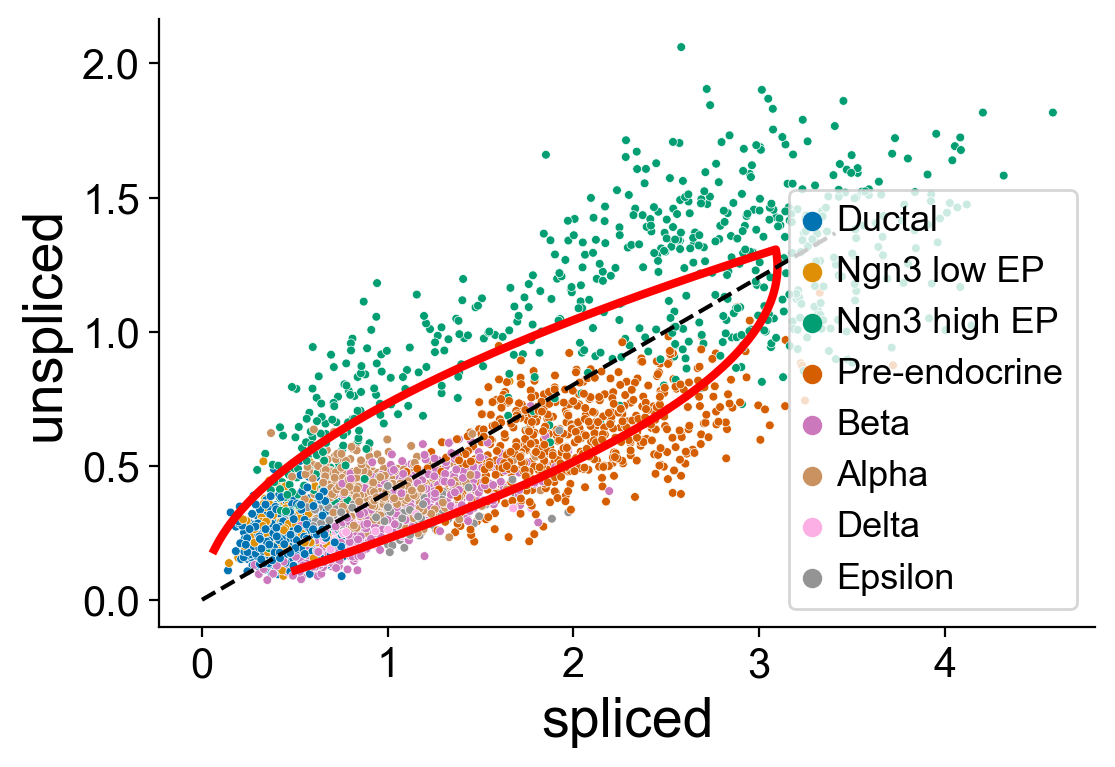

In [59]:
from scipy.stats import rankdata
def get_mean_splicing(u0, s0, alpha_, beta_, gamma_, time_):
    pb = np.exp(-beta_ * time_)
    pg = np.exp(-gamma_ * time_)
    u_ss = alpha_ / beta_
    s_ss = alpha_ / gamma_
    u_t = u0 * pb + u_ss * (1 - pb)
    s_t = s0 * pg + s_ss * (1 - pg) + ((alpha_ - beta_ * u0) / (gamma_ - beta_)) * \
        (pg - pb)
    return u_t, s_t

gene_name = "Ppp3ca"
gene_ = np.where(adata_scvelo.var_names == gene_name)[0][0]
x = adata_scvelo.layers['Ms'][:, gene_].copy()
y = adata_scvelo.layers['Mu'][:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

alpha_ = adata_scvelo.var['fit_alpha'].values[gene_].copy()
beta_ = adata_scvelo.var['fit_beta'].values[gene_].copy()
gamma_ = adata_scvelo.var['fit_gamma'].values[gene_].copy()
scaling_ = adata_scvelo.var['fit_scaling'].values[gene_].copy()

plt_ = sns.scatterplot(x=x, y=(y * scaling_), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)
# up model
t_switch = adata_scvelo.var['fit_t_'].values[gene_].copy()
time_ = np.linspace(0, t_switch, 10000)
u0 = 0.0
s0 = 0.0
u_up, s_up = get_mean_splicing(u0, s0, alpha_, beta_, gamma_, time_)
plt_ = sns.lineplot(x=st[:, gene_], \
                    y=ut[:, gene_] * scaling_, color="red", sort=False, linewidth=3)
tmax = 24
time_ = np.linspace(0, tmax / 24 - t_switch, 10000)
alpha_ = 1e-10
u_dn, s_dn = get_mean_splicing(u_up[-1], s_up[-1], alpha_, beta_, gamma_, time_)

plt_.plot([0, s_up[-1]], [0, s_up[-1] * (gamma_ / beta_) * scaling_], color="black", \
            linestyle="dashed")
plt_.set_xlabel("spliced", fontsize=20)
plt_.set_ylabel("unspliced", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend(fontsize=13)
sns.despine()

### Figure 3k: unspliecd vs spliced for Map1b

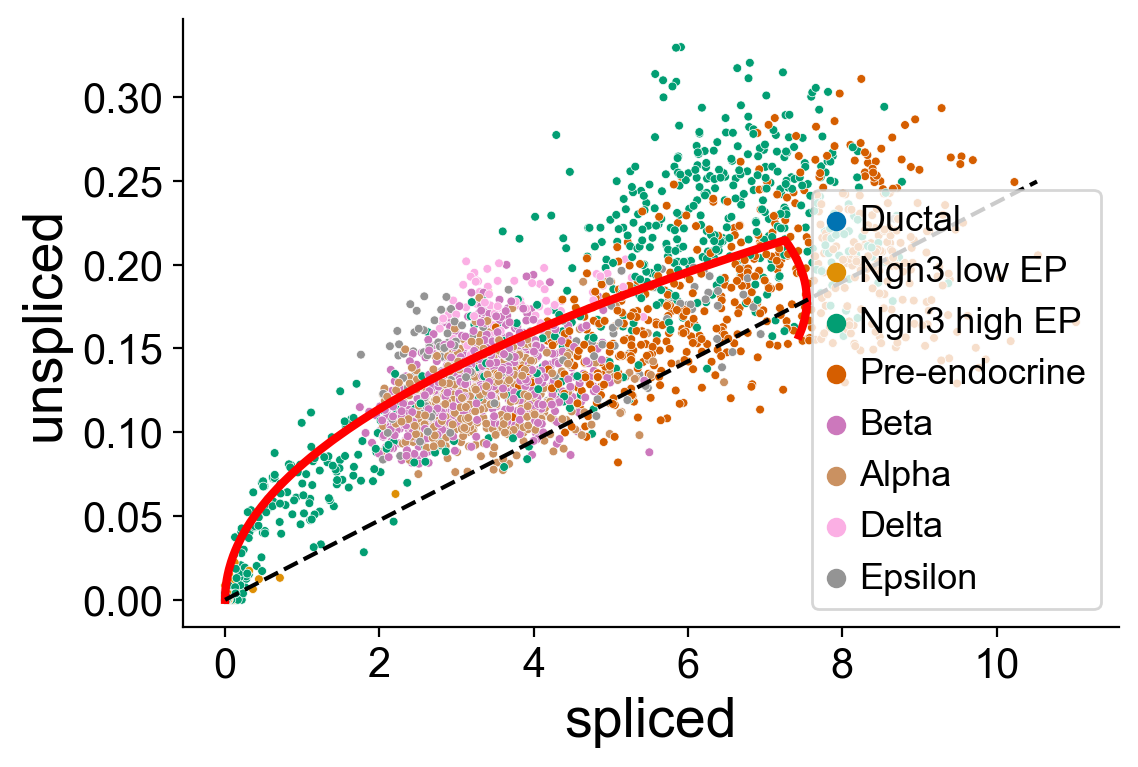

In [61]:
from scipy.stats import rankdata
def get_mean_splicing(u0, s0, alpha_, beta_, gamma_, time_):
    pb = np.exp(-beta_ * time_)
    pg = np.exp(-gamma_ * time_)
    u_ss = alpha_ / beta_
    s_ss = alpha_ / gamma_
    u_t = u0 * pb + u_ss * (1 - pb)
    s_t = s0 * pg + s_ss * (1 - pg) + ((alpha_ - beta_ * u0) / (gamma_ - beta_)) * \
        (pg - pb)
    return u_t, s_t

gene_name = "Map1b"
gene_ = np.where(adata_scvelo.var_names == gene_name)[0][0]
x = adata_scvelo.layers['Ms'][:, gene_].copy()
y = adata_scvelo.layers['Mu'][:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

alpha_ = adata_scvelo.var['fit_alpha'].values[gene_].copy()
beta_ = adata_scvelo.var['fit_beta'].values[gene_].copy()
gamma_ = adata_scvelo.var['fit_gamma'].values[gene_].copy()
scaling_ = adata_scvelo.var['fit_scaling'].values[gene_].copy()

plt_ = sns.scatterplot(x=x, y=(y * scaling_), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)
# up model
t_switch = adata_scvelo.var['fit_t_'].values[gene_].copy()
time_ = np.linspace(0, t_switch, 10000)
u0 = 0.0
s0 = 0.0
u_up, s_up = get_mean_splicing(u0, s0, alpha_, beta_, gamma_, time_)
plt_ = sns.lineplot(x=st[:, gene_], \
                    y=ut[:, gene_] * scaling_, color="red", sort=False, linewidth=3)
tmax = 24
time_ = np.linspace(0, tmax / 24 - t_switch, 10000)
alpha_ = 1e-10
u_dn, s_dn = get_mean_splicing(u_up[-1], s_up[-1], alpha_, beta_, gamma_, time_)

plt_.plot([0, s_up[-1]], [0, s_up[-1] * (gamma_ / beta_) * scaling_], color="black", \
            linestyle="dashed")
plt_.set_xlabel("spliced", fontsize=20)
plt_.set_ylabel("unspliced", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend(fontsize=13)
sns.despine()